In [1]:
from fastjsonschema.ref_resolver import normalize

from fractal_compressor import FractalCompressor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from PIL import ImageCms
import pickle
import gzip
import json
from pathlib import Path

import time
import struct
import os

In [2]:
image_path = "../images/lena.png"
compressed_image_path = "../out/compressed.fic"
decompressed_image_path = "../out/decompressed.png"

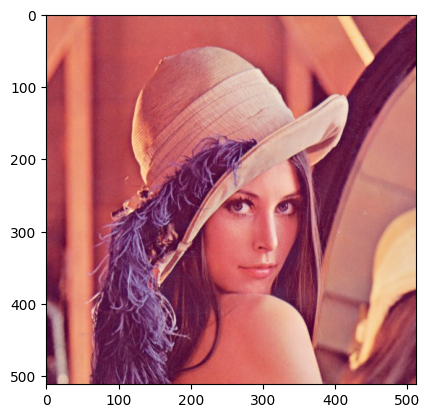

In [3]:
image = Image.open(image_path)
plt.imshow(image)

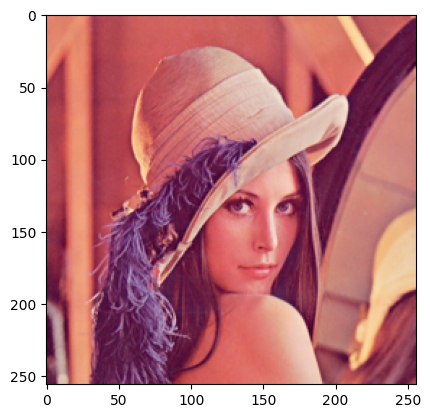

In [4]:
resized_image = image.resize((256,256))
plt.imshow(resized_image)

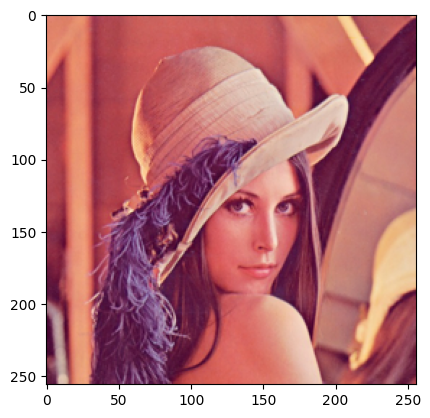

In [5]:
img_ycbcr = resized_image.convert("YCbCr")
plt.imshow(img_ycbcr)

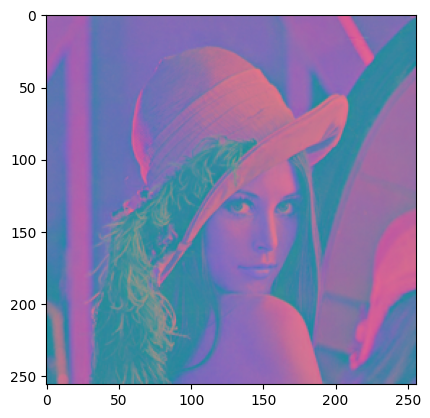

In [6]:
array_img = np.array(img_ycbcr)
normalized_img = array_img / 255.0
plt.imshow(normalized_img)

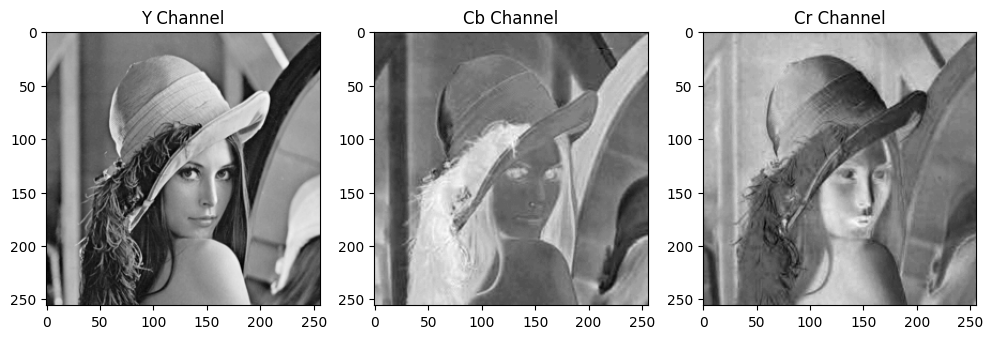

In [7]:
imgY = np.array(normalized_img)[:,:,0]
imgCb = np.array(normalized_img)[:,:,1]
imgCr = np.array(normalized_img)[:,:,2]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(imgY, cmap='gray')
axes[0].set_title('Y Channel')
axes[1].imshow(imgCb, cmap='gray')
axes[1].set_title('Cb Channel')
axes[2].imshow(imgCr, cmap='gray')
axes[2].set_title('Cr Channel')
plt.show()


In [8]:
compressor_8bs = FractalCompressor(block_size=8, step=4, max_orientations=1)
compressor_16bs = FractalCompressor(block_size=16, step=16)

In [9]:
Y_transforms = compressor_8bs.compress_frame(imgY)
Cb_transforms = compressor_16bs.compress_frame(imgCb)
Cr_transforms = compressor_16bs.compress_frame(imgCr)

  [Frame] Blocs 8x8, Step 4, Sources: 3721, Max orientations: 1
  Compression: 8.11s, Ratio: 4.00x, Jobs: 11
  [Frame] Blocs 16x16, Step 16, Sources: 225, Max orientations: 4
  Compression: 1.33s, Ratio: 16.00x, Jobs: 11
  [Frame] Blocs 16x16, Step 16, Sources: 225, Max orientations: 4
  Compression: 1.26s, Ratio: 16.00x, Jobs: 11


In [10]:
def save_compressed_image(filepath, compressed_data, metadata=None, compress_level=6):
    """
    Sauvegarde une image compressée de manière optimisée et extensible.

    Args:
        filepath: Chemin du fichier (.fic ou .fic.gz recommandé)
        compressed_data: Dict contenant les transformations
            Format attendu: {
                'Y': transforms_list,
                'Cb': transforms_list,
                'Cr': transforms_list,
                'shape': (h, w),
                # + tout autre champ personnalisé
            }
        metadata: Dict optionnel avec infos supplémentaires
        compress_level: Niveau de compression gzip (0-9)
    """
    filepath = Path(filepath)

    # Structure du fichier
    data = {
        'version': '1.0',  # Pour compatibilité future
        'compressed_data': compressed_data,
        'metadata': metadata or {},
    }

    # Sérialisation avec pickle (compact et rapide)
    serialized = pickle.dumps(data, protocol=pickle.HIGHEST_PROTOCOL)

    # Compression gzip
    with gzip.open(filepath, 'wb', compresslevel=compress_level) as f:
        f.write(serialized)

    # Stats
    size_kb = filepath.stat().st_size / 1024
    print(f"Sauvegardé: {filepath} ({size_kb:.2f} KB)")

    return filepath

In [11]:
save_compressed_image(compressed_image_path, {"Y": Y_transforms, "Cb": Cb_transforms, "Cr": Cr_transforms})

Sauvegardé: ../out/compressed.fic (30.01 KB)


PosixPath('../out/compressed.fic')

In [12]:
Y_decompressed = compressor_8bs.decompress_frame(Y_transforms, imgY.shape)
#Y_decompressed = imgY
Cb_decompressed = compressor_16bs.decompress_frame(Cb_transforms, imgY.shape,)
Cr_decompressed = compressor_16bs.decompress_frame(Cr_transforms, imgY.shape)

  Décompression: 0.56s (8 itérations)
  Décompression: 0.07s (8 itérations)
  Décompression: 0.07s (8 itérations)


In [13]:
decompressed_image_ycbcr = np.stack((Y_decompressed, Cb_decompressed, Cr_decompressed), axis=-1)

In [14]:
decompressed_image_ycbcr *= 255.0
decompressed_image_ycbcr = decompressed_image_ycbcr.astype(np.uint8)

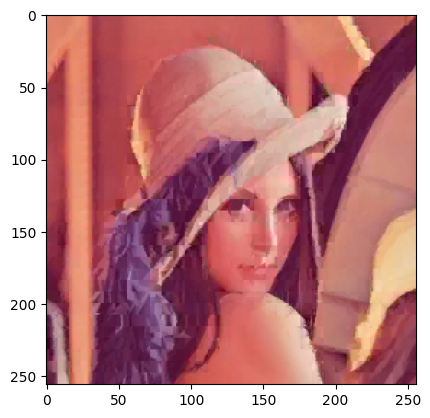

In [15]:
decompressed_image_rgb = Image.fromarray(decompressed_image_ycbcr, 'YCbCr').convert('RGB')
plt.imshow(decompressed_image_rgb)

In [16]:
decompressed_image_rgb.save(decompressed_image_path)

In [17]:
def compute_psnr(self, original, reconstructed):
    """Calcule le PSNR entre l'image originale et reconstruite."""
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0  # Images normalisées entre 0 et 1
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def evaluate(self, original, reconstructed):
    """
    Évalue la qualité de la compression.

    Returns:
        dict avec MSE, PSNR, ratio de compression, etc.
    """
    mse = np.mean((original - reconstructed) ** 2)
    psnr = self.compute_psnr(original, reconstructed)

    stats = self.last_compression_stats.copy()
    stats.update({
        'mse': mse,
        'psnr': psnr,
    })

    return stats

def print_stats(self, stats):
    """Affiche les statistiques de manière lisible."""
    print("\n=== Statistiques de compression ===")
    print(f"Temps compression:    {stats['time']:.2f}s")
    print(f"Blocs traités:        {stats['blocks']}")
    print(f"Comparaisons filtrées: {stats['filter_ratio'] * 100:.1f}%")
    print(f"Taille originale:     {stats['original_size']} bytes")
    print(f"Taille compressée:    {stats['transform_size']} bytes")
    print(f"Ratio compression:    {stats['compression_ratio']:.2f}x")
    print(f"MSE:                  {stats['mse']:.6f}")
    print(f"PSNR:                 {stats['psnr']:.2f} dB")
    print("=" * 35)